In [1]:
%load_ext jupyternotify
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion
import TSPN 

import sim_template as sim
from importlib import reload 

<IPython.core.display.Javascript object>

In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [3]:
#Setup the communication environment:

#For now, use same channel params
nPL = 6.4
kPL = -20

decorrSH = 2.09  
alpha = 30
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.75



#6 remote stations
l = 11
qBase = np.array([[11,10], [11-(np.sqrt(2)*l/2), 10-(np.sqrt(2)*l/2)], [14,10], [14+(np.sqrt(2)*l/2), 10-(np.sqrt(2)*l/2)],
                  [12.5, 10+2*np.sqrt(2)], [12.5,10+2*np.sqrt(2) + l]])
cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 25
x_min = 0
y_max = 25
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
n = 3
p_th = 0.5

#Polling System Setup
bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
print(beta)
els = [0.3/beta, 0.01/beta, 0.01/beta]
print(els)

0.0625
[4.8, 3.2, 0.16]


In [4]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


In [5]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)
trismall_pcs = pcs
#%store trismall_pcs
print(prob_pred_con)

Drawing 625 samples from Channel 1
Completed PredictedChannel 1
Drawing 625 samples from Channel 2
Completed PredictedChannel 2
Drawing 625 samples from Channel 3
Completed PredictedChannel 3
Drawing 625 samples from Channel 4
Completed PredictedChannel 4
Drawing 625 samples from Channel 5
Completed PredictedChannel 5
Drawing 625 samples from Channel 6
Completed PredictedChannel 6
[0.8334018922254216, 0.8588469184890656, 0.8468571428571429]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


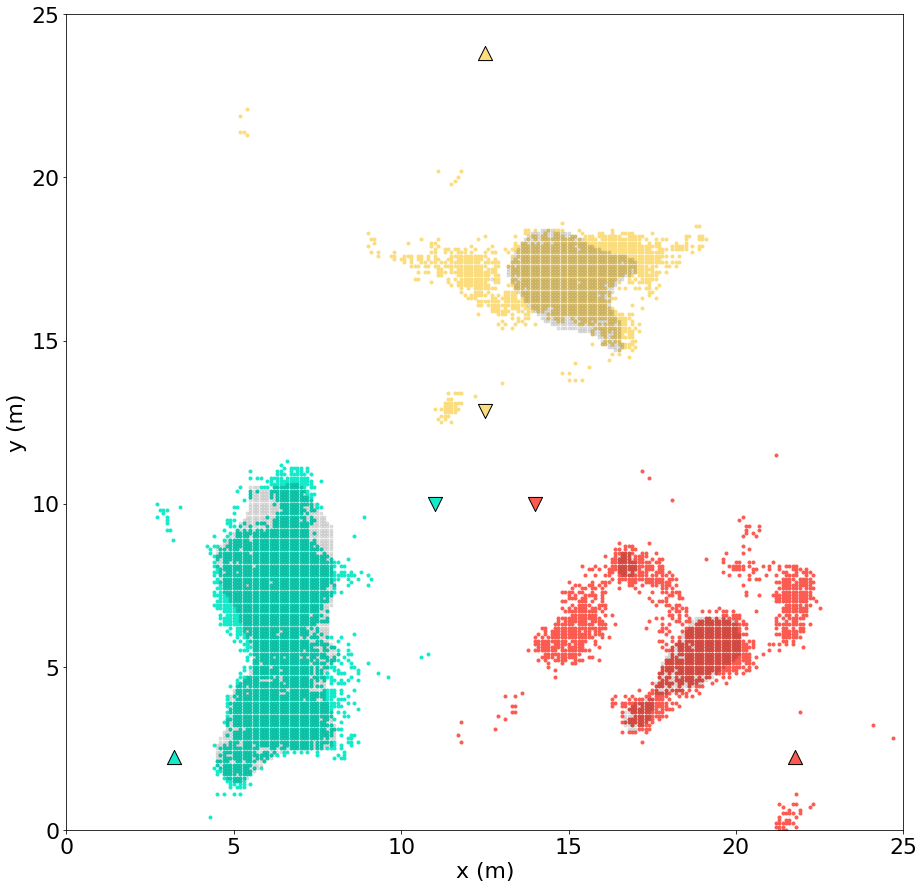

In [6]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [8]:
reload(dtr)
dt_sys = dtr.DTR(pcs, region, els, beta, th=GAMMA_TH, p_th = p_th)

Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
9 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
7 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
6 total subregions


Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Academic license - for non-commercial use only - expires 2022-07-30
Using license file /opt/gurobi912/gurobi.lic
Optimal Solution Improved to 25.02
Elapsed Time: 0.19


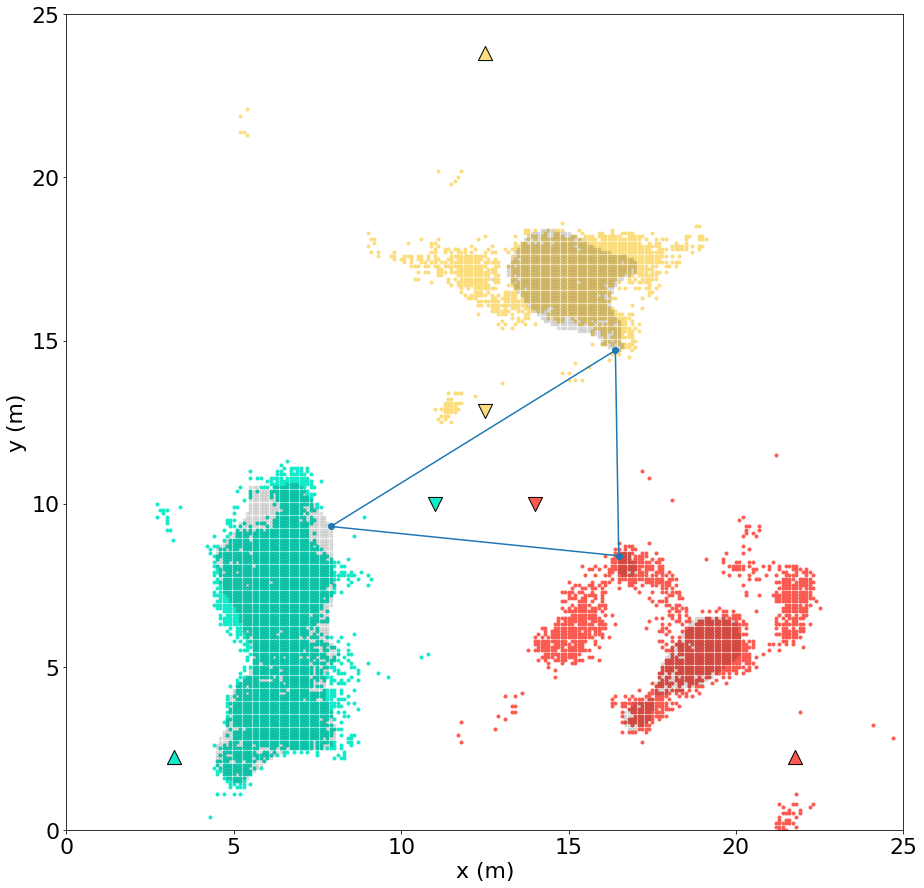

(0, 1, 2)

In [9]:
#Calculate baseline TSPN policy
# import gurobi_solvers as GB
# reload(GB)
# reload(TSPN)
regions = dt_sys.cregions
tspn_min, tspn_argmin = TSPN.TSPN_BF(regions)
x=tspn_argmin[0]

reload(sim)
order = list(tspn_argmin[1])
order.append(0)#complete the loop
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.plot(x[order,0], x[order,1], zorder=100)
plt.scatter(x[:,0], x[:,1], zorder = 100)
plt.gca().invert_yaxis()
plt.show()

tspn_argmin[1]

In [10]:
reload(dtr)
reload(sim)

v = 1
AORP = sim.calc_AORP(dt_sys, v)

    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 35.6395
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 35.3256
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 35.2833
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 35.2834
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 17.7343
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 17.6580
    model.name="unknown";
  

In [11]:
%%notify
reload(sim)
TSPNP={'X':x, 'SEQ':tspn_argmin[1]}
hrs = 0
mins = 30
seconds = 0

for i in range(len(vs)):
    v = vs[i]
    print('Velocity = %.1f'%(v))
    AORP = AORPS[i]
    motion_power = motion.LinearMotionPower(7.2, 0.29, v)
    sim.run_sims(dt_sys.ps, AORP, TSPNP, hrs, mins, seconds, motion_power, MOBILE_TX_POWER.W, v)


Velocity = 0.5
Theotretical MB serviced: 14688.0
Theoretical Energy Consumption (J): 3522.78
	Th. WT	WT	E (J)	MBS	MBR
AORP	35.28	34.48	3620.32	14360.55	309.55
Tab	---	33.56	3603.40	14404.90	279.75
TSPN	---	37.59	3614.20	14354.50	287.80
Velocity = 1.0
Theotretical MB serviced: 14688.0
Theoretical Energy Consumption (J): 6697.9800000000005
	Th. WT	WT	E (J)	MBS	MBR
AORP	17.66	17.44	6751.89	14609.20	132.25
Tab	---	17.04	6771.11	14576.70	129.75
TSPN	---	18.95	6792.51	14519.15	158.15
Velocity = 5.0
Theotretical MB serviced: 14688.0
Theoretical Energy Consumption (J): 32099.579999999998
	Th. WT	WT	E (J)	MBS	MBR
AORP	3.56	3.56	32262.42	14622.70	30.30
Tab	---	3.46	32224.26	14640.95	27.50
TSPN	---	3.83	32257.98	14627.65	30.50


<IPython.core.display.Javascript object>

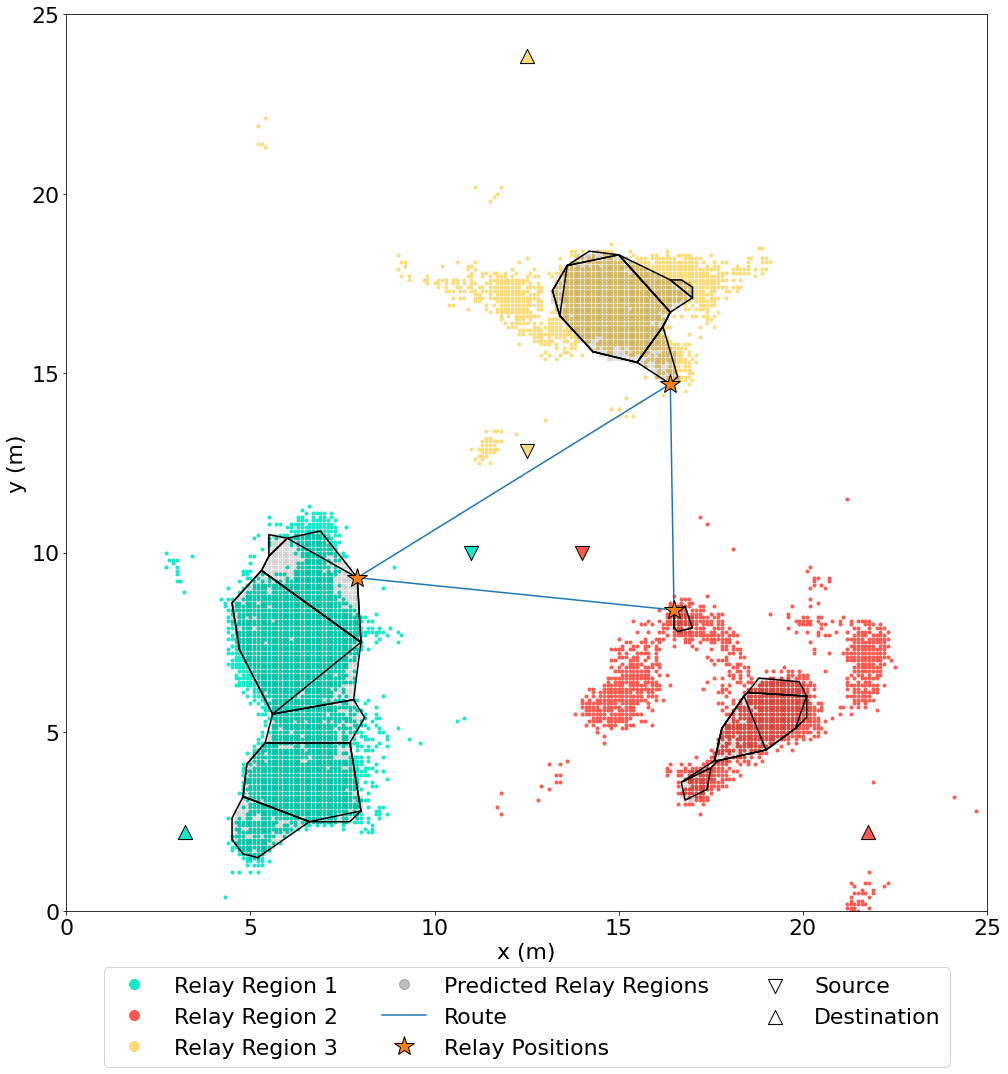

In [12]:
reload(sim)
sim.plot_TSPNP(dt_sys, TSPNP, tjcps, pjcps, qBase, region)
sim.save_plt('eq_tri_small_TSPNP.png')

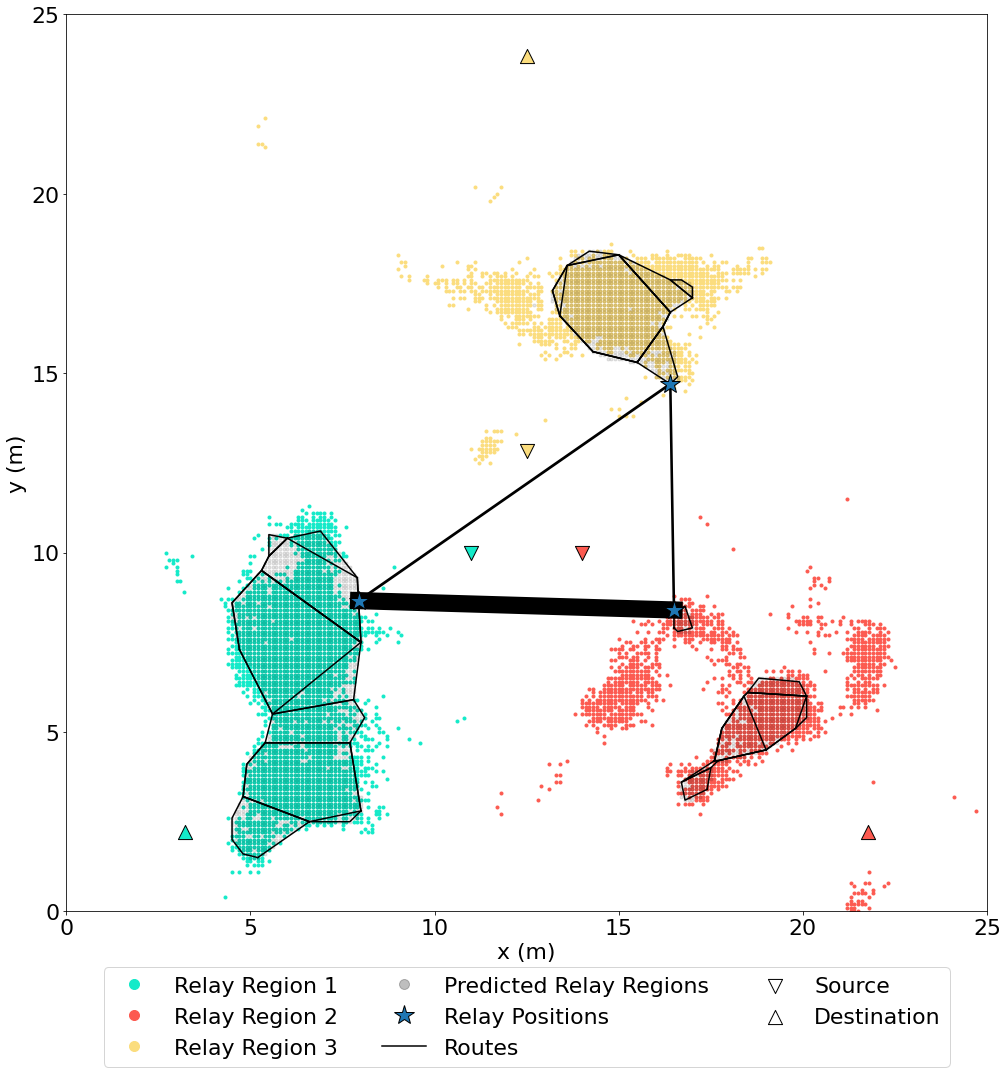

In [13]:
reload(sim)
sim.plot_AORP(dt_sys, AORPS[0], tjcps, pjcps, qBase, region)
sim.save_plt('eq_tri_small_AORP_v02.png')

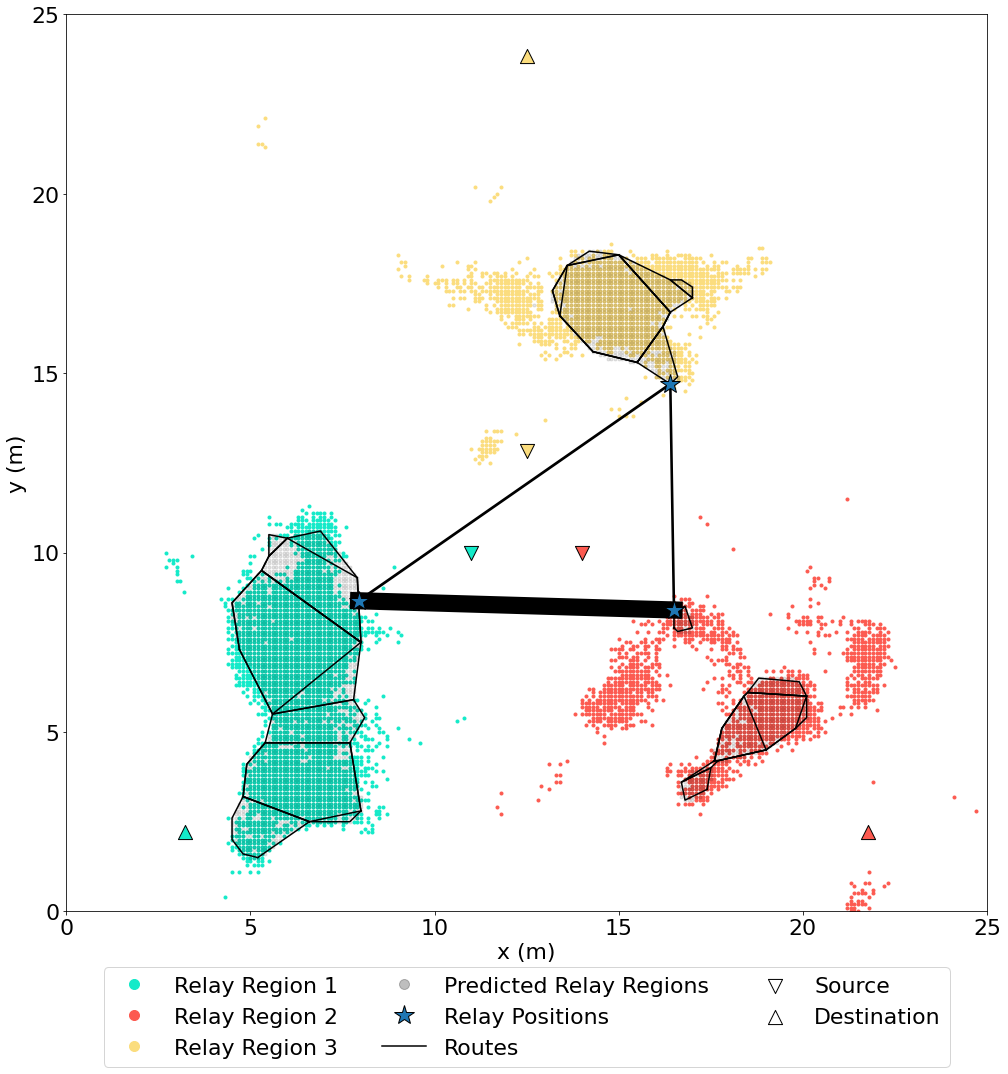

In [14]:
reload(sim)
sim.plot_AORP(dt_sys, AORPS[1], tjcps, pjcps, qBase, region)
sim.save_plt('eq_tri_small_AORP_v1.png')

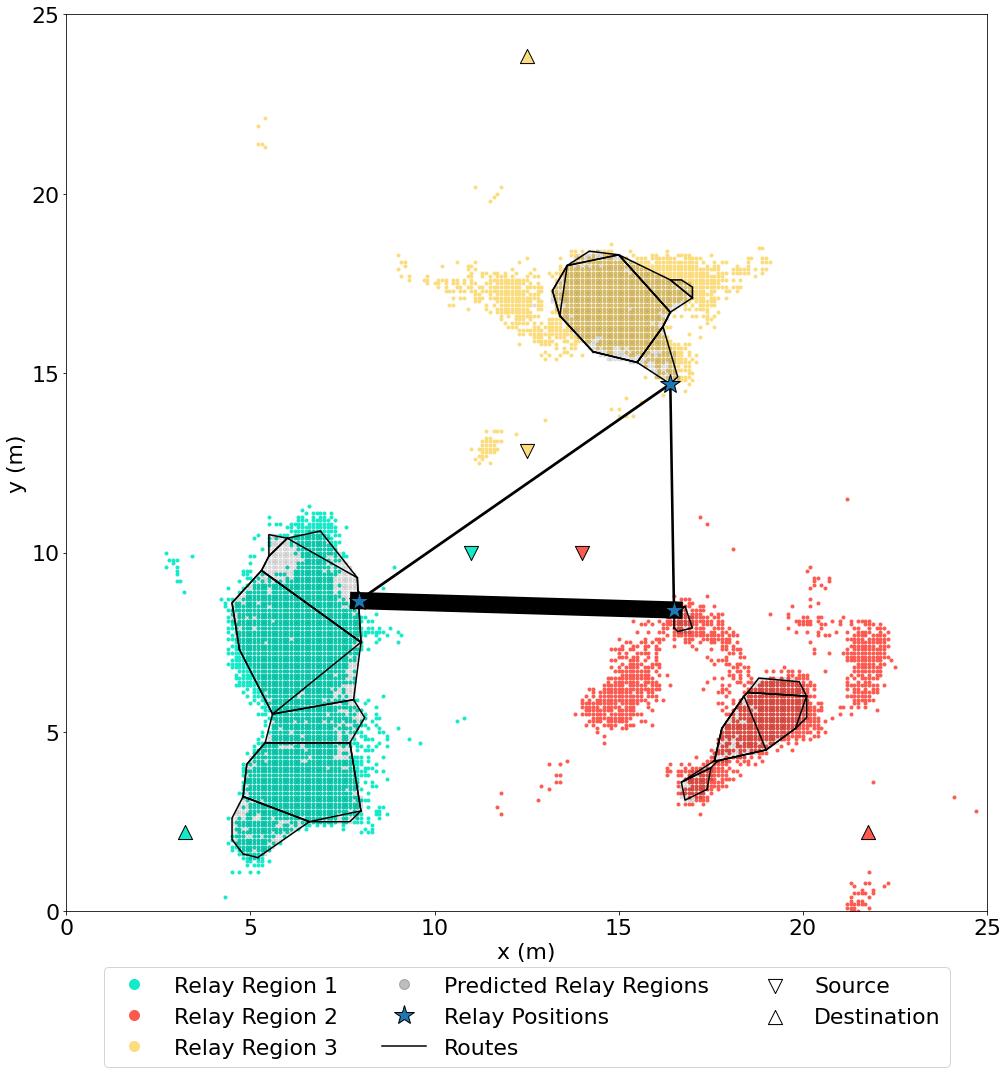

In [15]:
reload(sim)
sim.plot_AORP(dt_sys, AORPS[2], tjcps, pjcps, qBase, region)
sim.save_plt('eq_tri_small_AORP_v5.png')

In [ ]:
els2 = [0.3/beta, 0.01/beta, 0.01/beta]
dt_sys.ps = PS.PollingSystem(els2, beta)
